# Figure 8 Average Feature Importance $\Delta\!$ MLT Fits removed

In this notebook we show how perform the feature importance to find the predictive power of different variables for $\Delta\!$ MLT after the removal of the linear By fit and the sine clock fit.
This notebook produces Figure 8 in the related paper.

## Imports
First we import the functions we need

In [1]:
from multiprocessing import Pool # We use this to speed up the code by performing operations at the same time on different cpus
from sklearn.model_selection import train_test_split # This allows us to sample our dataset
from sklearn.ensemble import RandomForestRegressor # Key component for feature importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import iqr
from Boxplot import add_boxkey # Used to make a box plot key in figure

## Settings
settings needed for all the plotting

In [2]:
colors= ['#003f5c', '#bc5090', '#ffa600']

medianprops={'color':colors[0], 'lw':2}
meanprops= {'color':colors[1], 'lw':2}
boxplot={'medianprops':medianprops, 'meanprops':meanprops}
barchart={'color':colors[2]}

# Loading Dataset
Loading Onset file and created $\Delta\!$ MLT column

In [3]:
Onsets= pd.read_csv('./Mediated_Onsets.csv', parse_dates=['Date_NH'])
Onsets= Onsets[Onsets.flag==1][['Date_NH', 'Frey_MLT', 'Frey_MLAT', 'MLT_SH']]
Onsets.loc[Onsets.Frey_MLT<12, 'Frey_MLT']+=24
Onsets.loc[Onsets.MLT_SH<12, 'MLT_SH']+=24
Onsets['DMLT']= Onsets['MLT_SH']-Onsets['Frey_MLT']

## Rounding Time
Rounding the NH image time to the nearest minute

In [4]:
diff= Onsets.Date_NH-Onsets.Date_NH.values.astype('datetime64[m]')
delta= np.zeros(diff.shape).astype('timedelta64[m]')
delta[diff.values>=np.timedelta64(30, 's')]=np.timedelta64(1, 'm')
Onsets['Date_UTC']=Onsets.Date_NH.values.astype('datetime64[m]').astype('datetime64[ns]')+delta

## Loading Omni
Load the omni data and set values to 'NaN' when the required number of data points in the window is not satisfied.

In [5]:
omni= pd.read_hdf('./omni_data.hdf5', key='omni_window_2h_20')
omni.loc[omni['points']<120*.9, ['BX_GSE_Mean','BY_GSM_Mean',
                                 'BZ_GSM_Mean','Clock_GSM_SEM',
                                 'Clock_GSM_Mean']]=np.nan
omni['Date_UTC']= omni.index.values
omni.index= list(range(len(omni)))

## Merging Omni and Onset dataframes using the time column
We also calculate the sin and cosine of the clock angle (bow shock only) and the mean clock angle (window averaged and time shifted)

In [6]:
Onsets= Onsets.merge(omni, on='Date_UTC')

Onsets['Sin(Clock_GSM_Mean)']= np.sin(Onsets.Clock_GSM_Mean)
Onsets['Cos(Clock_GSM_Mean)']= np.cos(Onsets.Clock_GSM_Mean)
Onsets['Sin(Clock_GSM)']= np.sin(Onsets.Clock_GSM)
Onsets['Cos(Clock_GSM)']= np.cos(Onsets.Clock_GSM)


## Selecting Feature Columns

In [7]:
columns= ['Cos(Clock_GSM)', 'Sin(Clock_GSM)', 'BY_GSM',
          'Cos(Clock_GSM_Mean)', 'Sin(Clock_GSM_Mean)',
          'BX_GSE_Mean','BY_GSM_Mean', 'BZ_GSM_Mean',
           'AL_INDEX', 'AU_INDEX', 'ASY_H', 'SYM_H', 'Dipole_Tilt']
# Fixing decimal accuracy as sometimes unphysical accuracy appears
for col in ['DMLT', 'Frey_MLAT']+columns:
    Onsets[col]= np.round(Onsets[col], 15)

## Creating Random Feature
We fix the seed so the results are reproducable

In [8]:
np.random.seed(42)
Onsets['Random']= np.random.uniform(0, 1, size=len(Onsets))

## Fit Removal
We remove the linear By fit and the sine clock angle fit

In [9]:
#%% Fit removal
with open('./fitting_params.txt', 'r') as fits:
    fits= eval(fits.read())

def By_fit(x, m, c):
    return m*x +c
def Clock_fit(x, a, b, c):
    x= np.deg2rad(x)
    return a*np.sin(x+b) + c
Onsets['DMLT_BY_Corrected']= Onsets['DMLT']-By_fit(Onsets['BY_GSM_Mean'], **fits['BY'])
Onsets['DMLT_Clock_Corrected']= Onsets['DMLT']-Clock_fit(Onsets['Clock_GSM_Mean'], **fits['Clock'])

## Handling Outliers
We use 1.5 times the interquartile range over and under the upper and lower quartiles to define outliers and exclude them from feature importance

In [10]:
# Outliers
upper_lim= Onsets.DMLT<np.quantile(Onsets.DMLT, .75)+iqr(Onsets.DMLT)*1.5
lower_lim= Onsets.DMLT>np.quantile(Onsets.DMLT, .25)-iqr(Onsets.DMLT)*1.5
rm_out= upper_lim&lower_lim
Onsets= Onsets[rm_out&Onsets.BY_GSM_Mean.notnull()&Onsets.BY_GSM.notnull()] # we also remove rows with no bowshock omni and averaged omni that does not have enough data points in the window

## Feature Importance Definition
We create the feature importance function and set the seeds for seed cycling and repeated cross validation.
We also define X and y where X is are features we want to find the importance for and y is the feature to predict ($\Delta\!$ MLT)

In [11]:
X= Onsets[['Random', 'Frey_MLAT']+columns]
y = Onsets.DMLT_BY_Corrected

# Define the number of splits and list of seeds
n_splits = 20
seed_list = [42, 123, 456, 789, 101112]  # list of seeds

def train_and_get_feature_importance(seed):
    # Initialize feature importance list for this seed
    seed_feature_importance = []
    
    # Repeat train-test split and model training for each split
    for split_seed in [246, 357, 468, 579, 680, 791, 802, 913, 1024, 1135, 1246, 
              1357, 1468, 1579, 1680, 1791, 1802, 1913, 2024, 2135]:
        # Perform train-test split with current seed
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_seed) # This is used to create a sample of 80% of the data points to use in the feature importance
        
        # Initialize and train Random Forest Regressor
        rf_regressor = RandomForestRegressor(random_state=seed)
        rf_regressor.fit(X_train, y_train)
        
        # Get feature importance and append to list
        seed_feature_importance.append(rf_regressor.feature_importances_)
    
    # Return mean feature importance for this seed
    return np.array(seed_feature_importance)


## Run Feature Importance
We use pool to speed up the feature importance so that more than one feature importance is being calculated at the same time and we output it into one array. This creates our distribution of feature importance

In [12]:
# Create a Pool of workers
with Pool() as pool:
    # Map the train_and_get_feature_importance function to the seed_list
    feature_importance = pool.map(train_and_get_feature_importance, seed_list)
feature_importance_By= np.concatenate(feature_importance)
# Calculate mean feature importance across all seeds
FI_By= mean_feature_importance = np.mean(feature_importance_By, axis=0)


In [13]:
X= Onsets[['Random', 'Frey_MLAT']+columns]
y = Onsets.DMLT_Clock_Corrected

# Define the number of splits and list of seeds
n_splits = 20
seed_list = [42, 123, 456, 789, 101112]  # list of seeds

def train_and_get_feature_importance(seed):
    # Initialize feature importance list for this seed
    seed_feature_importance = []
    
    # Repeat train-test split and model training for each split
    for split_seed in [246, 357, 468, 579, 680, 791, 802, 913, 1024, 1135, 1246, 
              1357, 1468, 1579, 1680, 1791, 1802, 1913, 2024, 2135]:
        # Perform train-test split with current seed
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_seed) # This is used to create a sample of 80% of the data points to use in the feature importance
        
        # Initialize and train Random Forest Regressor
        rf_regressor = RandomForestRegressor(random_state=seed)
        rf_regressor.fit(X_train, y_train)
        
        # Get feature importance and append to list
        seed_feature_importance.append(rf_regressor.feature_importances_)
    
    # Return mean feature importance for this seed
    return np.array(seed_feature_importance)


## Run Feature Importance
We use pool to speed up the feature importance so that more than one feature importance is being calculated at the same time and we output it into one array. This creates our distribution of feature importance

In [14]:
# Create a Pool of workers
with Pool() as pool:
    # Map the train_and_get_feature_importance function to the seed_list
    feature_importance = pool.map(train_and_get_feature_importance, seed_list)
feature_importance_Clock= np.concatenate(feature_importance)
# Calculate mean feature importance across all seeds
FI_Clock= mean_feature_importance = np.mean(feature_importance_Clock, axis=0)


## Plotting Results
We use a bar chart for the average feature importance and box plots for each distribution

### Creating Figure and By Subplot

Text(0.5, 1.0, '$B_y$ Corrected')

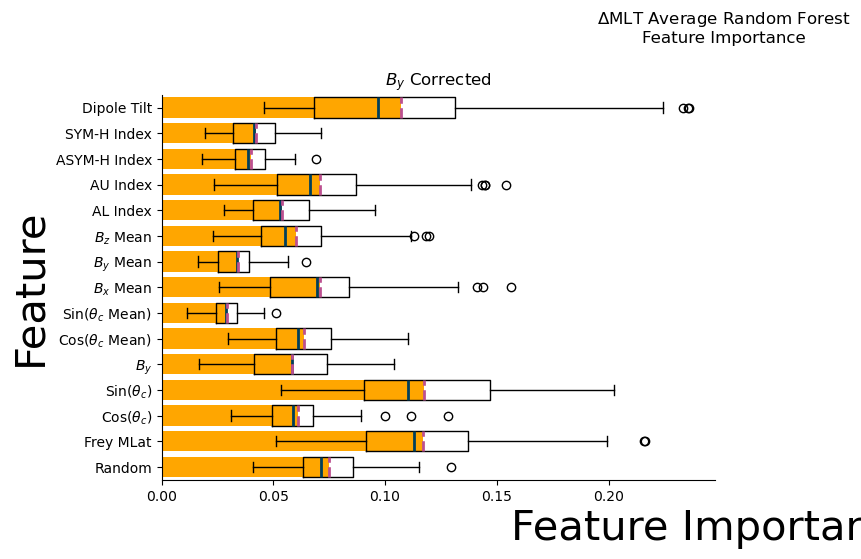

In [15]:
fig= plt.figure(figsize=(15, 5))
fig.suptitle('$\Delta$MLT Average Random Forest\nFeature Importance', y=1.05)
fig.subplots_adjust(wspace=0.1)
ax=fig.add_subplot(121)

bar= ax.barh(X.columns, FI_By, **barchart)

ax.boxplot(feature_importance_By, vert=False, positions=range(0, len(X.columns)),
           widths= [round(Bar.get_bbox().height, 1) for Bar in bar.get_children()],
           showmeans = True, meanline = True, **boxplot)

columns= ['Random','Frey MLat','Cos($\\theta_c$)', 'Sin($\\theta_c$)', '$B_y$',
          'Cos($\\theta_c$ Mean)', 'Sin($\\theta_c$ Mean)',
          '$B_x$ Mean','$B_y$ Mean', '$B_z$ Mean',
          'AL Index','AU Index', 'ASYM-H Index', 'SYM-H Index', 'Dipole Tilt']
ax.set_yticks(list(range(0, len(columns))))
ax.set_yticklabels(columns)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Feature', size=30)
ax.set_xlabel('Feature Importance', size=30, x=1)
ax.set_title(r'$B_y$ Corrected')

#### Creating Clock Angle Subplot

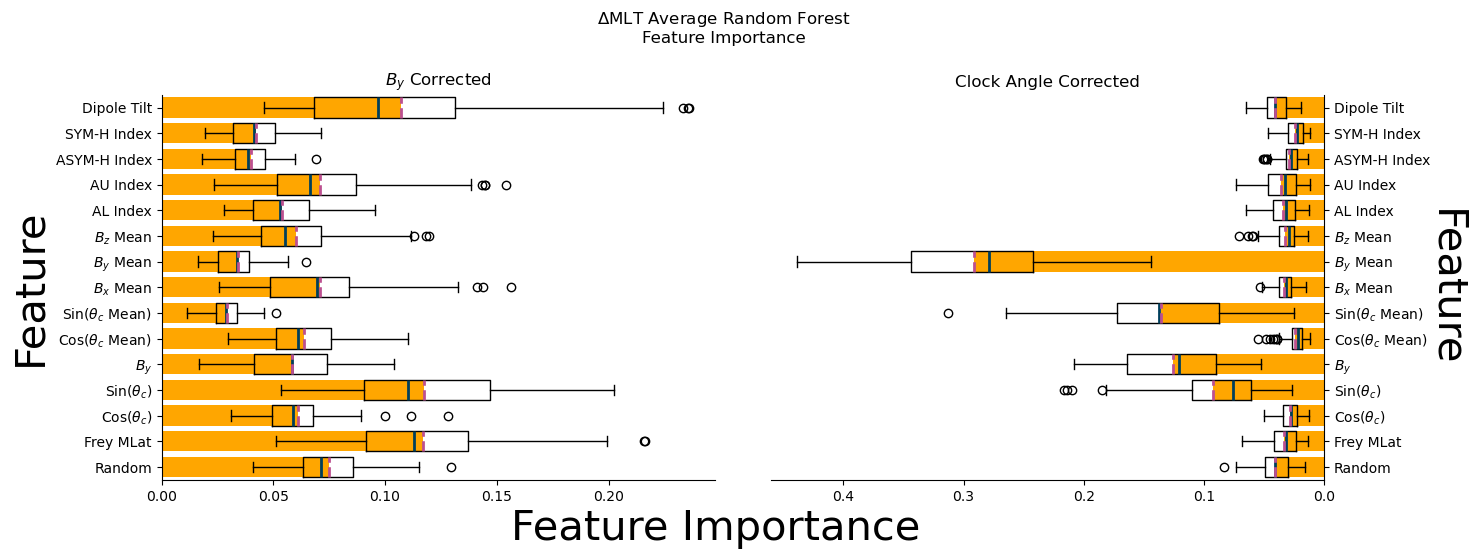

In [16]:
ax2=fig.add_subplot(122)
bar= ax2.barh(X.columns, FI_Clock, **barchart)
ax2.boxplot(feature_importance_Clock, vert=False, positions=range(0, len(X.columns)),
           widths= [round(Bar.get_bbox().height, 1) for Bar in bar.get_children()],
           showmeans = True, meanline = True, **boxplot)

columns= ['Random','Frey MLat','Cos($\\theta_c$)', 'Sin($\\theta_c$)', '$B_y$',
          'Cos($\\theta_c$ Mean)', 'Sin($\\theta_c$ Mean)',
          '$B_x$ Mean','$B_y$ Mean', '$B_z$ Mean',
          'AL Index','AU Index', 'ASYM-H Index', 'SYM-H Index', 'Dipole Tilt']
ax2.set_yticks(list(range(0, len(columns))))

ax2.set_yticklabels(columns)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('right')
ax2.set_ylabel('Feature', size=30, rotation=-90, labelpad=25)
ax2.set_title('Clock Angle Corrected')
ax2.invert_xaxis()
fig

### Setting limits and labels

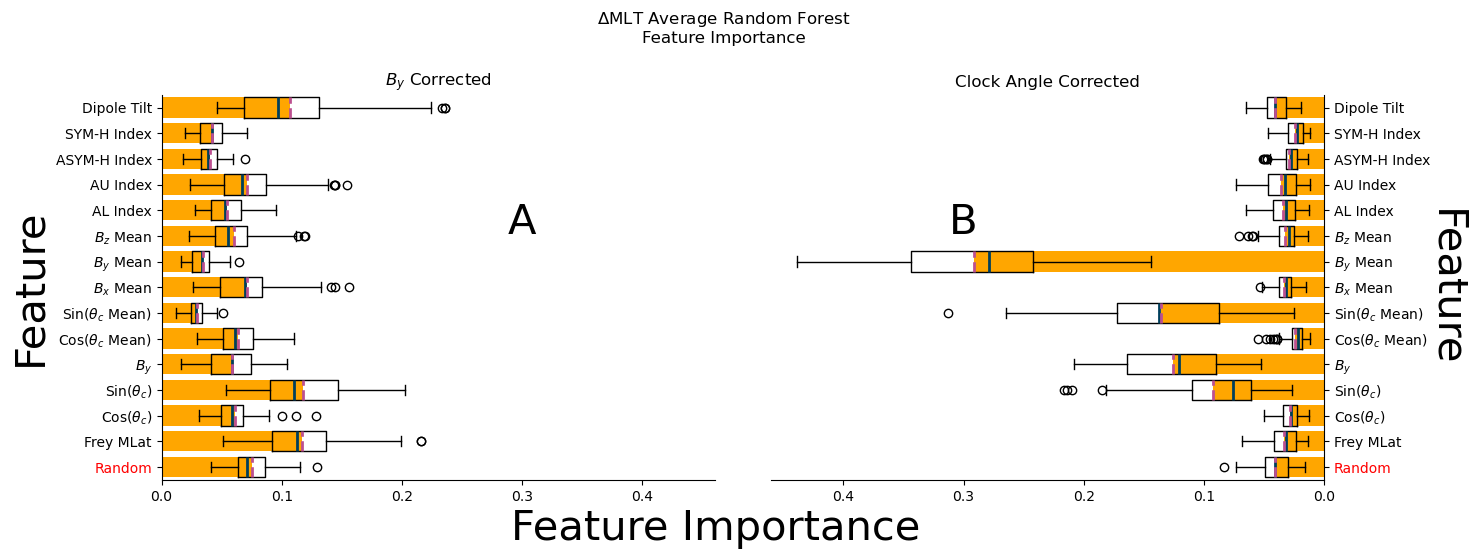

In [17]:
xlims= np.min([ax.get_xlim(), ax2.get_xlim()]), np.max([ax.get_xlim(), ax2.get_xlim()])
ax.sharey(ax2)
ax.set_xlim(xlims)
ax2.set_xlim(xlims)
ax2.invert_xaxis()
ax.get_yticklabels()[0].set_color('r')
ax2.get_yticklabels()[0].set_color('r')
ax.text(0.3, 9.5, 'A', va='center', ha='center', size=30, zorder=20000)
ax2.text(0.3, 9.5, 'B', va='center', ha='center', size=30, zorder=20000)
fig

### Creating Box plot key

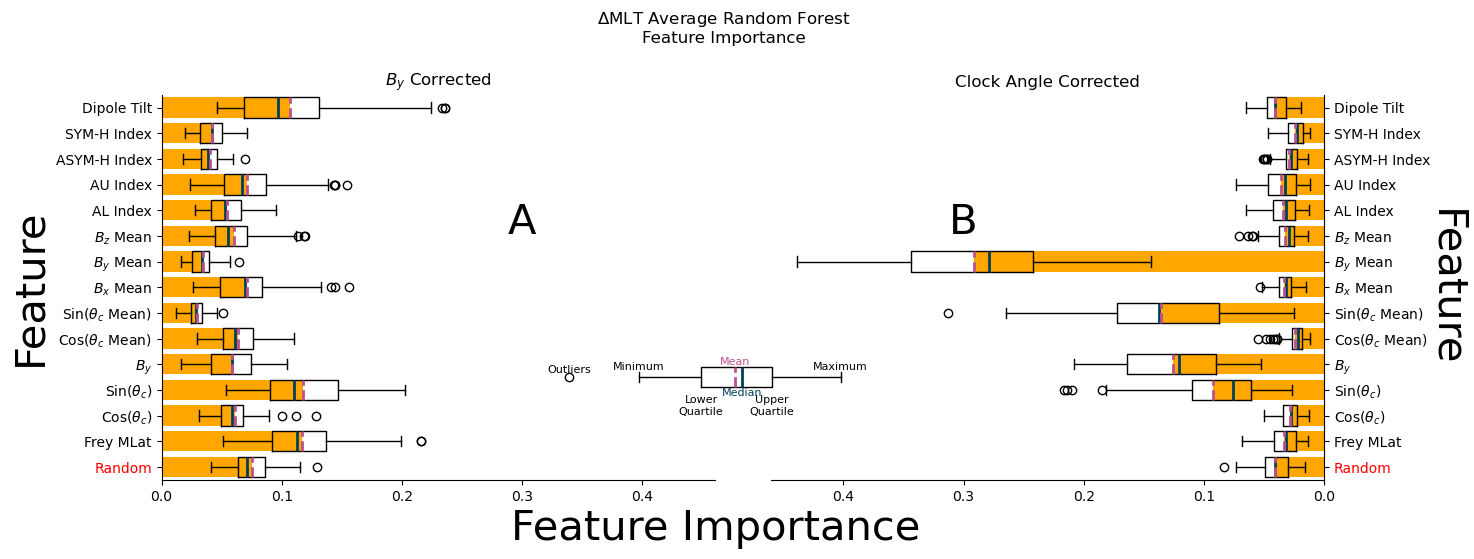

In [18]:
ax3= fig.add_subplot(111)
ax3.patch.set_alpha(0)
ax3.axis('off')
ax3.set_ylim(ax.get_ylim())
ax3.set_xlim(0, 1)

add_boxkey(ax3, width=[round(Bar.get_bbox().height, 1) for Bar in bar.get_children()][0],
           ypos=3.5, xshift=.15, boxplotkwargs=boxplot)
fig